In [1]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

from pcntoolkit.dataio.norm_data import NormData
from pcntoolkit.normative_model.norm_conf import NormConf
from pcntoolkit.normative_model.norm_factory import create_normative_model, load_normative_model
from pcntoolkit.normative_model.norm_hbr import NormHBR
from pcntoolkit.regression_model.hbr.hbr import HBR
from pcntoolkit.regression_model.hbr.hbr_conf import HBRConf
from pcntoolkit.regression_model.hbr.prior import make_prior
from pcntoolkit.util.plotter import plot_centiles, plot_qq

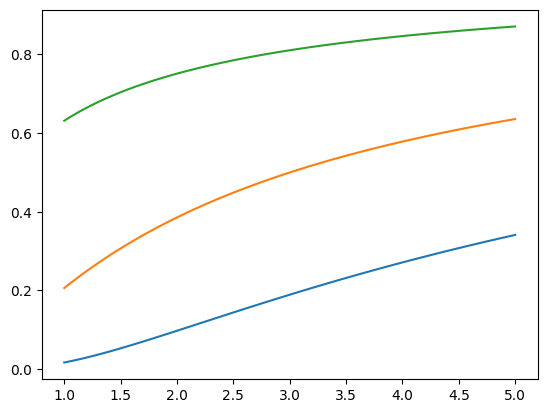

In [2]:
import numpy as np
import scipy.stats

a = np.linspace(1, 5, 100)
b = 3

cdf = [0.05, 0.5, 0.95]
for c in cdf:
    plt.plot(a, scipy.stats.beta.ppf(c, a, b))
plt.show()


In [3]:
# If you are running this notebook for the first time, you need to download the dataset from github.
# If you have already downloaded the dataset, you can comment out the following line
pd.read_csv(
    "https://raw.githubusercontent.com/predictive-clinical-neuroscience/PCNtoolkit-demo/refs/heads/main/data/fcon1000.csv"
).to_csv("resources/data/fcon1000.csv", index=False)
data = pd.read_csv("resources/data/fcon1000.csv")
covariates = ["age"]
batch_effects = ["sex", "site"]
response_vars = ["rh_MeanThickness_thickness", "WM-hypointensities"]
norm_data = NormData.from_dataframe(
    name="full",
    dataframe=data,
    covariates=["age"],
    batch_effects=["sex", "site"],
    response_vars=["rh_MeanThickness_thickness", "WM-hypointensities"],
)

# Leave two sites out for doing transfer and extend later
transfer_sites = ["Milwaukee_b", "Oulu"]
transfer_data, fit_data = norm_data.split_batch_effects({"site": transfer_sites}, names=("transfer", "fit"))

# Split into train and test sets
train, test = fit_data.train_test_split()
transfer_train, transfer_test = transfer_data.train_test_split()

In [15]:
save_dir = "resources/hbr/save_dir"
# Create a NormConf object
norm_conf = NormConf(
    savemodel=True,
    saveresults=True,
    save_dir=save_dir,
    inscaler="standardize",
    outscaler="minmax",
    basis_function="bspline",
    basis_function_kwargs={"order": 3, "nknots": 5},
)
alpha = make_prior(
    linear=True,
    slope=make_prior(dist_params=(0.0, 10.0)),
    intercept=make_prior(
        linear=False,
        random=True,
        mu=make_prior(dist_params=(0.0, 1.0)),
        sigma=make_prior(linear=False, random=False, dist_name="HalfCauchy", dist_args=(0.5)),
    ),
    mapping="softplus",
    mapping_params=(0.0, 2.0),
)
beta = make_prior(
    linear=True,
    slope=make_prior(dist_params=(0.0, 10.0)),
    intercept=make_prior(
        linear=False,
        random=True,
        mu=make_prior(dist_params=(1.0, 1.0)),
        sigma=make_prior(linear=False, random=False, dist_name="HalfCauchy", dist_args=(0.5)),
    ),
    mapping="softplus",
    mapping_params=(0.0, 2.0),
)
# Configure the HBRConf object
hbr_conf = HBRConf(
    draws=1500,
    tune=500,
    chains=4,
    pymc_cores=16,
    alpha=alpha,
    beta=beta,
    likelihood="beta",
    nuts_sampler="nutpie",
)

Process: 48667 - Configuration of normative model is valid.


## Combine normative and hbr conf in normative model
We can either use the NormHBR constructor, or the factory method to create a normative HBR model

In [16]:
# Using the constructor
norm_hbr = NormHBR(norm_conf=norm_conf, reg_conf=hbr_conf)
display(norm_hbr)
del norm_hbr

In [17]:
# Using the factory method
norm_hbr = create_normative_model(norm_conf, hbr_conf)
norm_hbr

In [18]:
predictions = norm_hbr.fit_predict(train, test)
# norm_hbr.predict(test)

Process: 48667 - Fitting and predicting 2 response variables.
Process: 48667 - Fitting and predicting model for rh_MeanThickness_thickness.


ValueError: Can't pass both tau and sigma

/opt/anaconda3/envs/dev_refactor_2/lib/python3.12/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (22), generating only 20 plots
  warnings.warn(


<Figure size 640x480 with 0 Axes>

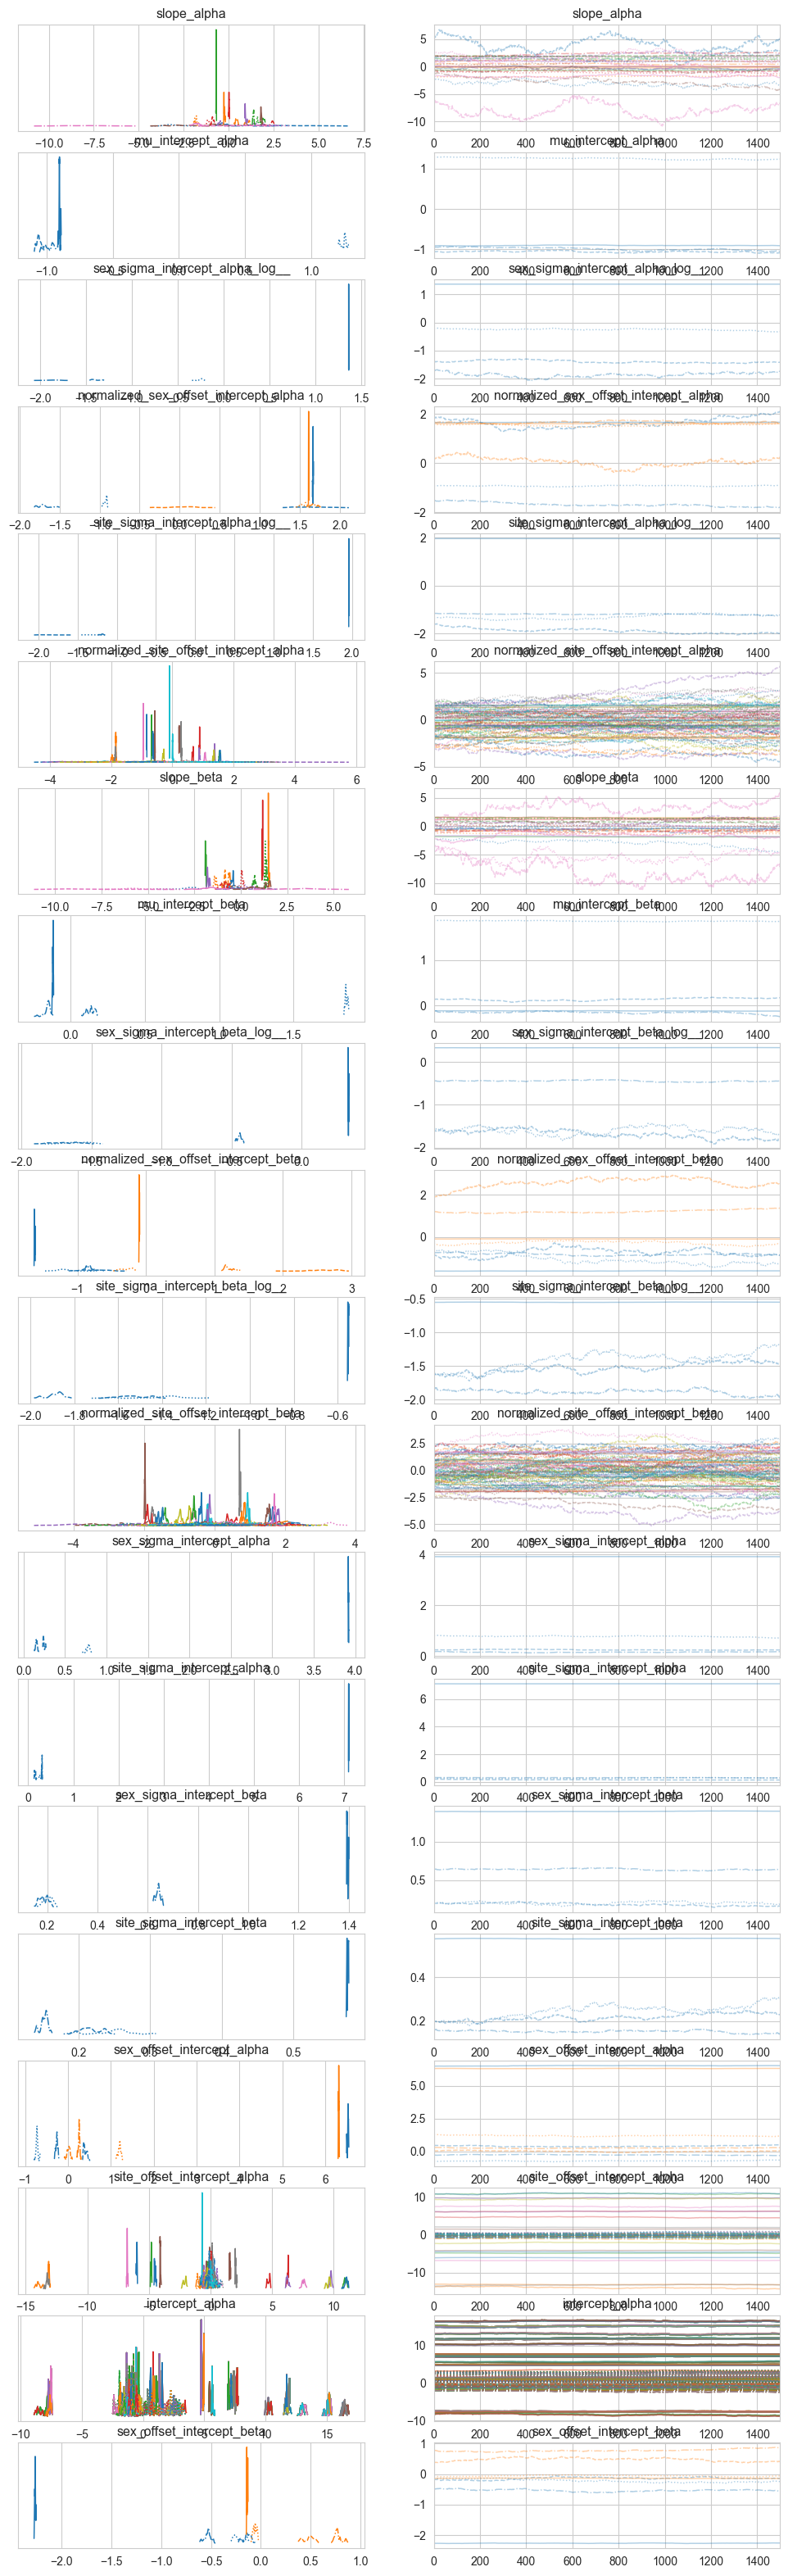

In [14]:
model: HBR = norm_hbr.regression_models.get("rh_MeanThickness_thickness")  # type: ignore

idata = model.idata  # type: ignore

plt.tight_layout()
az.plot_trace(
    idata.posterior,
    var_names=[
        "~alpha_samples",
        "~beta_samples",
    ],
)
plt.show()

## Inspecting the model 

The norm_hbr model contains a collection of regression models, one for each response variable. We can inspect those models individually by calling `norm_hbr.regression_models.get("{responsevar}")`

In [15]:
norm_hbr.predict(test)

/opt/anaconda3/envs/dev_refactor_2/lib/python3.12/site-packages/pcntoolkit/util/output.py:128: UserWarning: Process: 82138 - The dataset fit_test has unknown batch effects: {'sex': [], 'site': []}
  warnings.warn("Process: " + str(os.getpid()) + " - " + message.format(*args, **kwargs))
Sampling: [y_pred]


Output()

Process: 82138 - Making predictions on 2 response variables.
Process: 82138 - Making predictions on WM-hypointensities.


Sampling: [y_pred]


Output()

Process: 82138 - Making predictions on rh_MeanThickness_thickness.


Process: 82138 - Computing log-probabilities for 2 response variables.
Process: 82138 - Computing log-probabilities for WM-hypointensities.
Process: 82138 - Computing log-probabilities for rh_MeanThickness_thickness.
Process: 82138 - Computing z-scores for 2 response variables.
Process: 82138 - Computing z-scores for WM-hypointensities.


Sampling: [y_pred]
Sampling: [y_pred]
Sampling: [y_pred]


Process: 82138 - Computing z-scores for rh_MeanThickness_thickness.
Process: 82138 - Computing centiles for 2 response variables.
Process: 82138 - Computing centiles for WM-hypointensities.


Sampling: [y_pred]


Process: 82138 - Computing centiles for rh_MeanThickness_thickness.


Sampling: [y_pred]


Process: 82138 - Saving results to resources/hbr/save_dir.
Process: 82138 - Computing centiles for 2 response variables.
Process: 82138 - Computing centiles for WM-hypointensities.
Process: 82138 - Computing centiles for rh_MeanThickness_thickness.


Sampling: [y_pred]


<xarray.NormData> Size: 80kB
Dimensions:            (datapoints: 186, covariates: 1, response_vars: 2,
                        batch_effect_dims: 2, basis_functions: 3, cdf: 5,
                        measure: 8)
Coordinates:
  * datapoints         (datapoints) int64 1kB 515 441 1029 64 ... 640 648 635
  * covariates         (covariates) <U3 12B 'age'
  * response_vars      (response_vars) <U26 208B 'rh_MeanThickness_thickness'...
  * batch_effect_dims  (batch_effect_dims) <U4 32B 'sex' 'site'
  * basis_functions    (basis_functions) <U10 120B 'age_poly_0' ... 'age_poly_2'
  * cdf                (cdf) float64 40B 0.05 0.25 0.5 0.75 0.95
  * measure            (measure) <U8 256B 'MSLL' 'NLL' ... 'SMSE' 'ShapiroW'
Data variables:
    X                  (datapoints, covariates) float64 1kB 18.0 20.0 ... 20.0
    y                  (datapoints, response_vars) float64 3kB 2.456 ... 460.3
    batch_effects      (datapoints, batch_effect_dims) <U17 25kB '0' ... 'ICBM'
    scaled_X           (datapoints, covariates) float64 1kB -0.7465 ... -0.5937
    scaled_y           (datapoints, response_vars) float64 3kB -0.2694 ... -0...
    Phi                (datapoints, basis_functions) float64 4kB -0.7465 ... ...
    logp               (datapoints, response_vars) float64 3kB -0.9985 ... -3...
    zscores            (datapoints, response_vars) float64 3kB -0.6124 ... 4.158
    scaled_centiles    (cdf, datapoints, response_vars) float64 15kB -1.405 ....
    centiles           (cdf, datapoints, response_vars) float64 15kB 2.343 .....
    Yhat               (datapoints, response_vars) float64 3kB 2.536 ... 1.44...
    measures           (response_vars, measure) float64 128B -66.76 ... 0.979
Attributes:
    name:                  fit_test
    unique_batch_effects:  {'sex': ['0', '1'], 'site': ['AnnArbor_a', 'AnnArb...
    batch_effects_counts:  {'sex': {'0': 493, '1': 437}, 'site': {'AnnArbor_a...

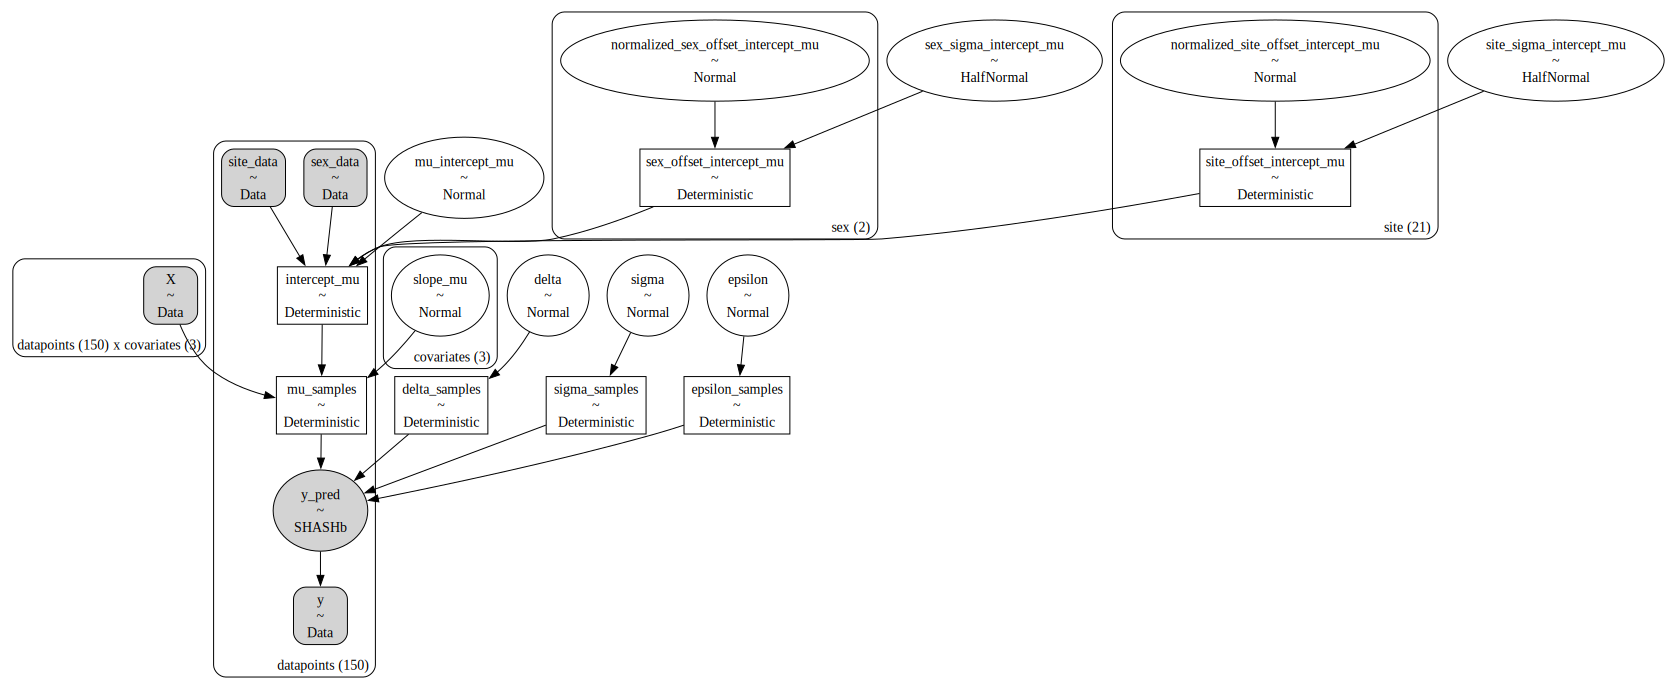

In [9]:
model: HBR = norm_hbr.regression_models.get("rh_MeanThickness_thickness")  # type: ignore
model.pymc_model.to_graphviz()  # type: ignore

We can use the arviz library to inspect the posterior samples (trace) of the model. Here we only use the 'plot_trace' function to inspect the trace of the model, but there are many other useful functions available. If you are not familiar with arviz, we recommend checking out the [arviz documentation](https://arviz-devs.github.io/arviz/index.html).


/opt/anaconda3/envs/dev_refactor_2/lib/python3.12/site-packages/arviz/utils.py:146: UserWarning: Items starting with ~: ['scaled_site_offset_intercept_mu', 'scaled_sex_offset_intercept_mu'] have not been found and will be ignored
  warnings.warn(


<Figure size 640x480 with 0 Axes>

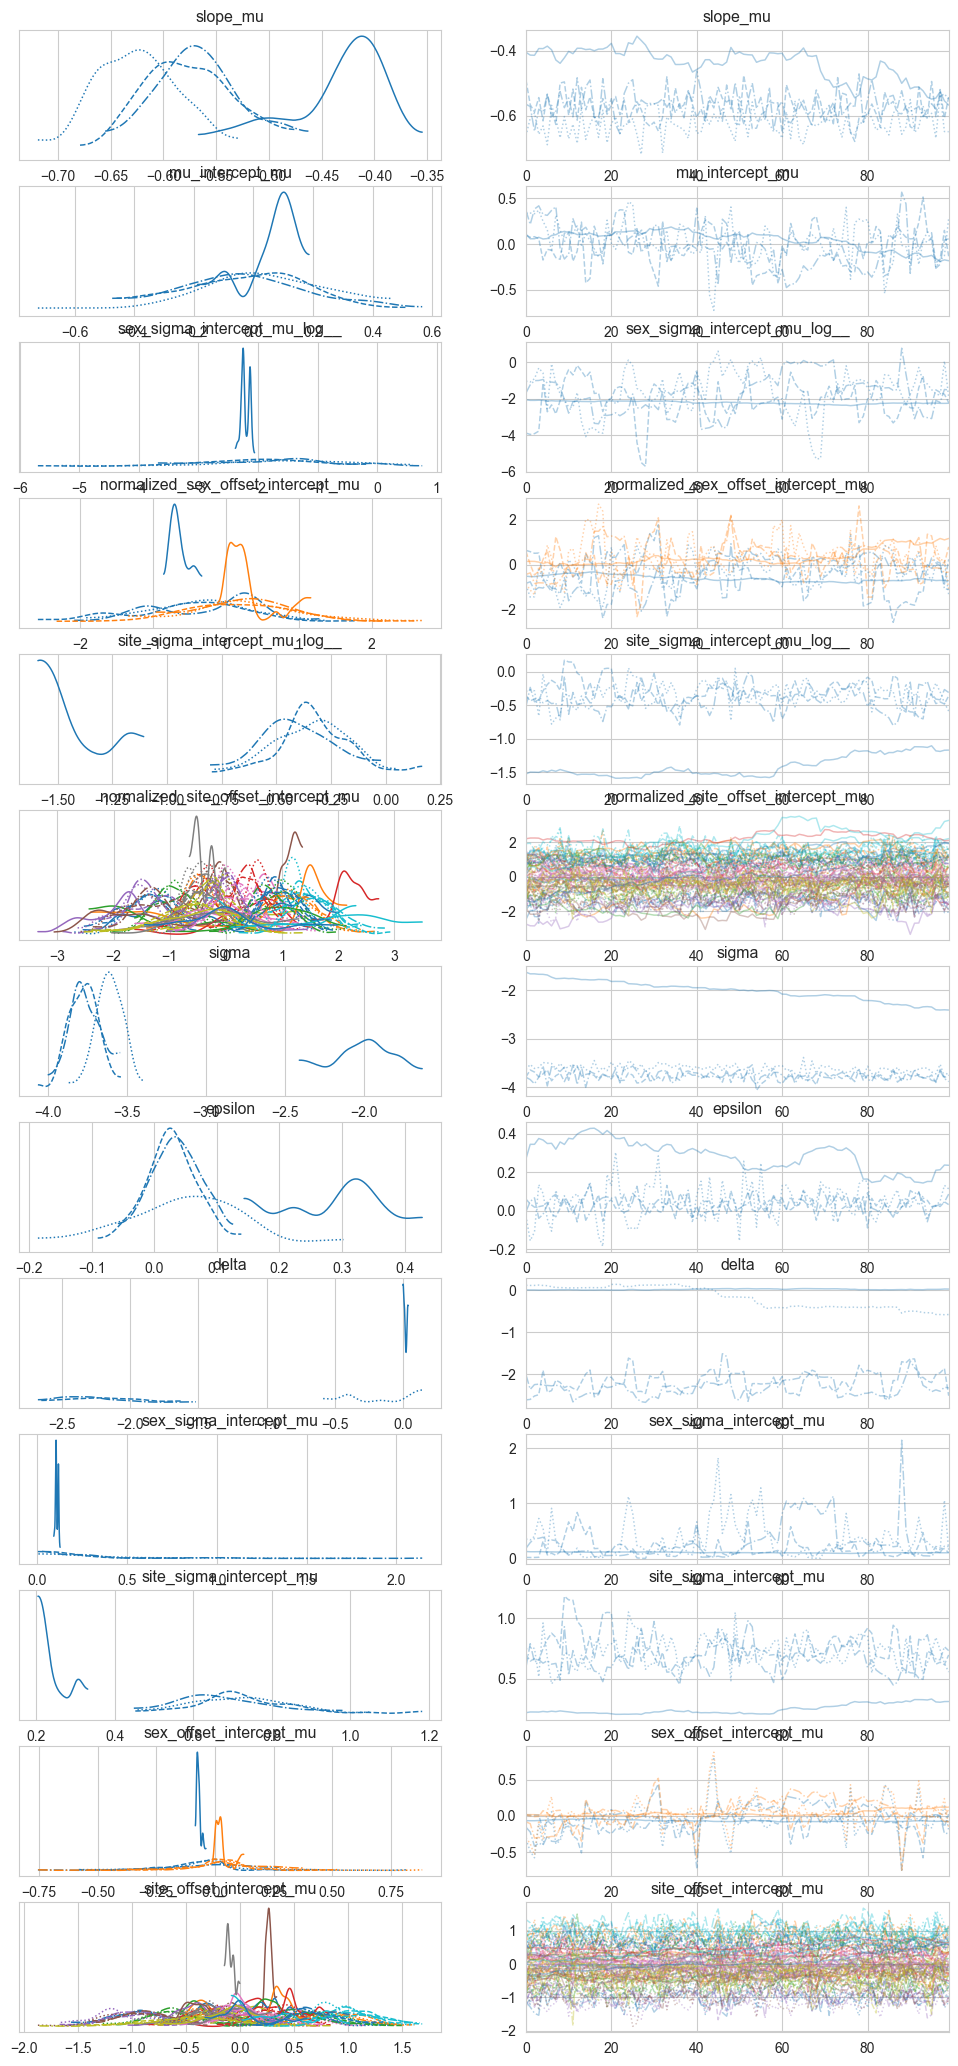

In [14]:
idata = model.idata  # type: ignore

plt.tight_layout()
az.plot_trace(
    idata.posterior,
    var_names=[
        "~mu_samples",
        "~sigma_samples",
        "~epsilon_samples",
        "~delta_samples",
        "~intercept_mu",
        "~scaled_site_offset_intercept_mu",
        "~scaled_sex_offset_intercept_mu",
    ],
)
plt.show()

## Evaluation
Calling `predict` will extend the predict_data object with a number of useful arrays.
1. `measures`: DataArray, which contains a number of evaluation statistics. 
1. `zscores`: the predicted z-scores for each datapoint.  
1. `centiles`: the predicted centiles of variation evaluated at each covariate in the dataset. 


In [15]:
display(test.measures.to_pandas().T)

response_vars,rh_MeanThickness_thickness,WM-hypointensities
measure,,
MSLL,-2.173153e+00,6.849320e+00
NLL,1.232927e+00,1.078199e+00
R2,3.583037e-01,2.403417e-01
RMSE,7.575168e-02,6.013872e+02
Rho,5.476065e-01,4.895571e-01
Rho_p,6.045789e-16,1.331739e-12
SMSE,3.582183e+01,2.645480e-07
ShapiroW,9.831849e-01,9.923980e-01


Datasets with a zscores DataArray will have the `.plot_qq()` function available:

In [16]:
display(test.zscores.to_pandas())  # the zscores

response_vars,rh_MeanThickness_thickness,WM-hypointensities
datapoints,,
515,-0.417032,-0.483331
441,-0.247419,-0.610338
1029,1.153737,0.148149
64,-1.708695,-0.117865
654,1.029266,-1.841151
...,...,...
611,-0.991325,1.516131
549,-1.228408,1.384249
640,0.141024,-1.343735


In [17]:
display(test.centiles.to_dataframe().unstack(level=["response_vars", "cdf"]))

centiles                     \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.05               0.05   
datapoints                                                    
515                             2.353344         731.128046   
441                             2.354117         819.210358   
1029                            2.436227         465.537739   
64                              2.298238         492.759334   
654                             2.295736         578.153156   
...                                  ...                ...   
611                             2.313386         643.220552   
549                             2.209644         652.905367   
640                             2.245103         647.197904   
648                             2.359800         579.929532   
635                             2.447636         371.018910   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.25               0.25   
datapoints                                                    
515                             2.432159        1112.842433   
441                             2.432932        1200.924745   
1029                            2.515042         847.252126   
64                              2.377053         874.473720   
654                             2.374551         959.867543   
...                                  ...                ...   
611                             2.392201        1024.934939   
549                             2.288459        1034.619754   
640                             2.323918        1028.912291   
648                             2.438615         961.643919   
635                             2.526451         752.733297   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.50               0.50   
datapoints                                                    
515                             2.492982        1568.644297   
441                             2.493754        1656.726609   
1029                            2.575865        1303.053990   
64                              2.437876        1330.275584   
654                             2.435374        1415.669407   
...                                  ...                ...   
611                             2.453024        1480.736803   
549                             2.349282        1490.421618   
640                             2.384741        1484.714155   
648                             2.499438        1417.445783   
635                             2.587273        1208.535161   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.75               0.75   
datapoints                                                    
515                             2.556035        2278.035313   
441                             2.556807        2366.117625   
1029                            2.638917        2012.445007   
64                              2.500928        2039.666601   
654                             2.498426        2125.060423   
...                                  ...                ...   
611                             2.516077        2190.127819   
549                             2.412334        2199.812634   
640                             2.447793        2194.105172   
648                             2.562490        2126.836799   
635                             2.650326        1917.926177   

                                                             
response_vars rh_MeanThickness_thickness WM-hypointensities  
cdf                                 0.95               0.95  
datapoints                                                   


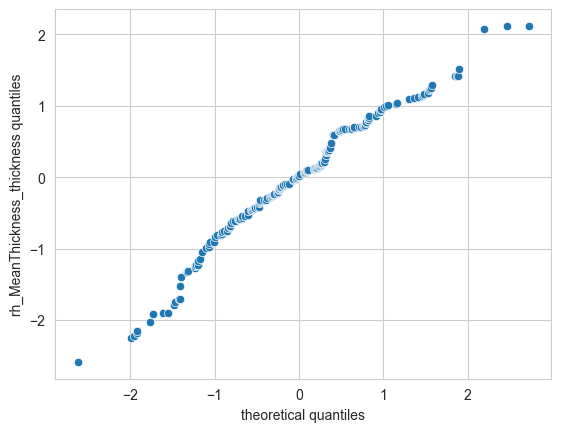

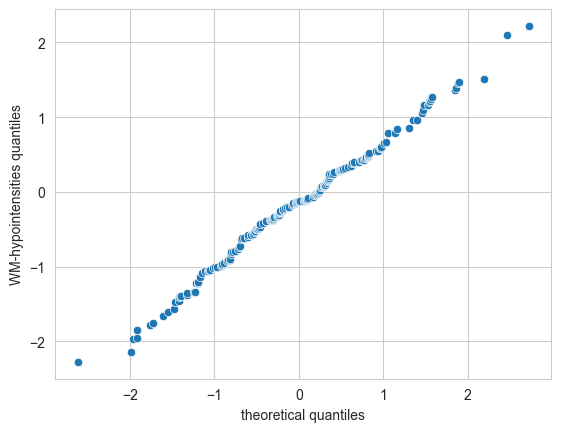

In [18]:
plot_qq(test)

And `plot_centiles()` can be called as a function of the model. A synthetic dataset is created internally, so we need to pass the original dataset (`train` in this case) as a template. We also need to pass which covariate is to be plotted on the x-axis, and the batch-effects for which the centiles are to be plotted. 

The lines correspond to the CDF values of: [0.05, 0.25, 0.5, 0.75, 0.95]. It is also possible to pass a list of CDF values to plot.

It may seem strange that the centiles do not match the plotted data, but that is because the centiles are calculated for a single batch effect, and it is superimposed on the full dataset. The blue markers correspond to the data for which the centiles are calculated. 

Sampling: [y_pred]


Process: 81999 - Computing centiles for 2 response variables.
Process: 81999 - Computing centiles for rh_MeanThickness_thickness.


Sampling: [y_pred]


Process: 81999 - Computing centiles for WM-hypointensities.


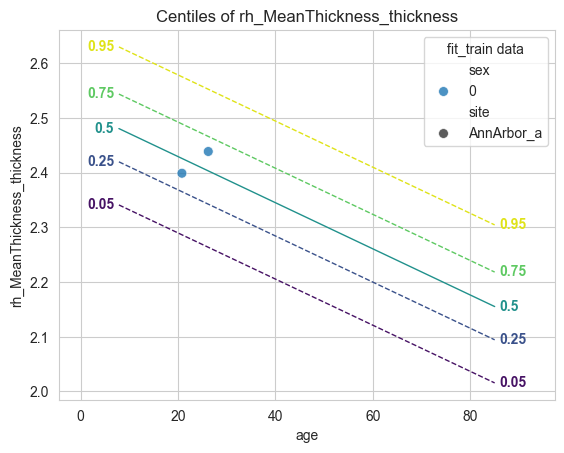

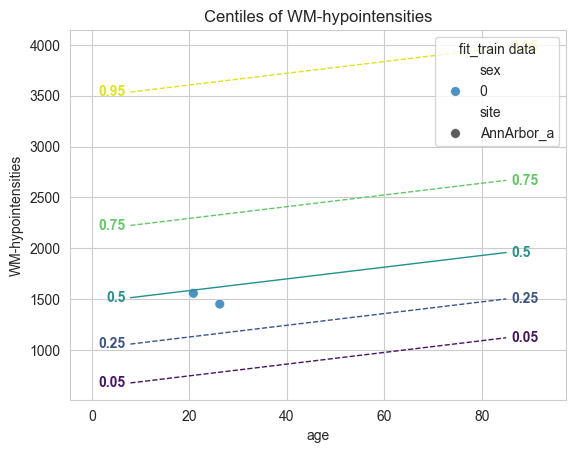

In [19]:
plot_centiles(
    norm_hbr,
    train,
    covariate="age",
    show_data=True,
    hue_data="sex",
    markers_data="site",
)

The values of 0.1587 and 0.8413 correspond to a standard deviation of -1 and 1. We plot the centiles again for these values, and we also highlight a specific site. 


Sampling: [y_pred]
Sampling: [y_pred]


Process: 81999 - Computing centiles for 2 response variables.
Process: 81999 - Computing centiles for rh_MeanThickness_thickness.
Process: 81999 - Computing centiles for WM-hypointensities.


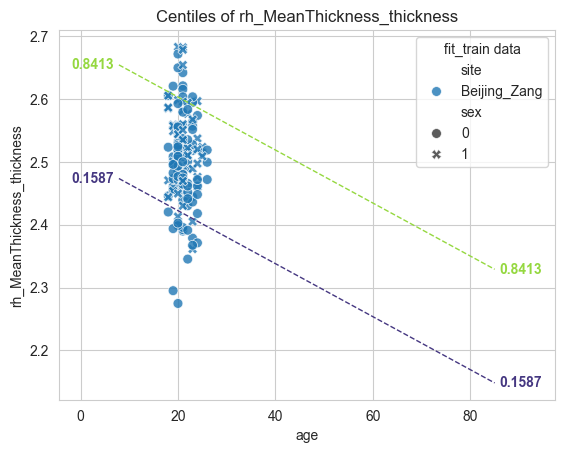

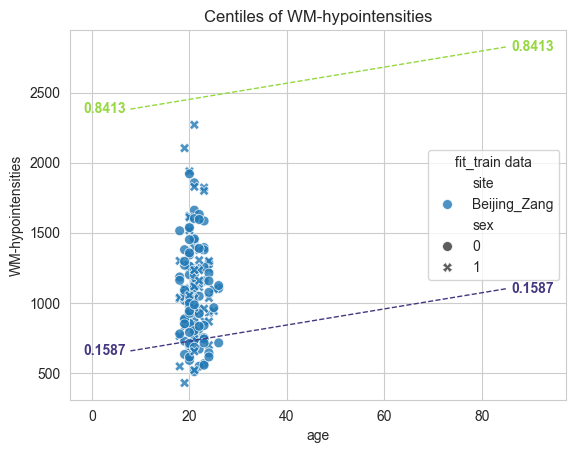

In [20]:
plot_centiles(
    norm_hbr,
    train,
    covariate="age",
    cummul_densities=[0.1587, 0.8413],
    show_data=True,
    batch_effects={"site": ["Beijing_Zang"]},
)

## Transfer

If we transfer to new dataset, we use the samples from the posterior to derive priors for a new model. That new model is then fitted on the new dataset. Our new model will not work on the old data. To give some extra control over the fit, we let the `freedom` parameter control the variance of the derived factorized posterior. Here we set it to something small (1e-4) to create a spike prior on the model parameters, to ensure that we do not 'forget' about what we learned from the original data. If we have a very large new dataset, we can set the freedom parameter to something bigger. 

In [23]:
save_dir = "resources/hbr/save_dir"
model = load_normative_model(save_dir)

transfered_model = model.transfer_predict(transfer_train, transfer_test, freedom=1e-4, nuts_sampler="nutpie")

Process: 81999 - Configuration of normative model is valid.
Process: 81999 - Configuration of normative model is valid.
Process: 81999 - Configuration of normative model is valid.
Process: 81999 - Transferring models on 2 response variables.
Process: 81999 - Transferring model for rh_MeanThickness_thickness.


Progress,Draws,Divergences,Step Size,Gradients/Draw
,150,0,0.07,15
,150,0,0.04,3
,150,0,0.09,1
,150,0,0.08,7


Process: 81999 - Transferring model for WM-hypointensities.


Progress,Draws,Divergences,Step Size,Gradients/Draw
,150,0,0.04,3
,150,0,0.13,7
,150,0,0.01,7
,150,0,0.03,3


/opt/anaconda3/envs/dev_refactor_2/lib/python3.12/site-packages/pcntoolkit/util/output.py:128: UserWarning: Process: 81999 - The dataset transfer_test has unknown batch effects: {'sex': [], 'site': []}
  warnings.warn("Process: " + str(os.getpid()) + " - " + message.format(*args, **kwargs))
Sampling: [y_pred]


Output()

Process: 81999 - Saving model to resources/hbr/save_dir_transfer.
Process: 81999 - Making predictions on 2 response variables.
Process: 81999 - Making predictions on rh_MeanThickness_thickness.


Sampling: [y_pred]


Output()

Process: 81999 - Making predictions on WM-hypointensities.


Process: 81999 - Computing log-probabilities for 2 response variables.
Process: 81999 - Computing log-probabilities for rh_MeanThickness_thickness.
Process: 81999 - Computing log-probabilities for WM-hypointensities.


Sampling: [y_pred]
Sampling: [y_pred]
Sampling: [y_pred]


Process: 81999 - Computing z-scores for 2 response variables.
Process: 81999 - Computing z-scores for rh_MeanThickness_thickness.
Process: 81999 - Computing z-scores for WM-hypointensities.
Process: 81999 - Computing centiles for 2 response variables.
Process: 81999 - Computing centiles for rh_MeanThickness_thickness.


Sampling: [y_pred]
Sampling: [y_pred]


Process: 81999 - Computing centiles for WM-hypointensities.
Process: 81999 - Saving results to resources/hbr/save_dir_transfer.
Process: 81999 - Computing centiles for 2 response variables.
Process: 81999 - Computing centiles for rh_MeanThickness_thickness.
Process: 81999 - Computing centiles for WM-hypointensities.


Sampling: [y_pred]


In [24]:
transfered_model.predict(transfer_test)

/opt/anaconda3/envs/dev_refactor_2/lib/python3.12/site-packages/pcntoolkit/util/output.py:128: UserWarning: Process: 81999 - The dataset transfer_test has unknown batch effects: {'sex': [], 'site': []}
  warnings.warn("Process: " + str(os.getpid()) + " - " + message.format(*args, **kwargs))
Sampling: [y_pred]


Output()

Process: 81999 - Making predictions on 2 response variables.
Process: 81999 - Making predictions on rh_MeanThickness_thickness.


Sampling: [y_pred]


Output()

Process: 81999 - Making predictions on WM-hypointensities.


Process: 81999 - Computing log-probabilities for 2 response variables.
Process: 81999 - Computing log-probabilities for rh_MeanThickness_thickness.
Process: 81999 - Computing log-probabilities for WM-hypointensities.


Sampling: [y_pred]
Sampling: [y_pred]
Sampling: [y_pred]


Process: 81999 - Computing z-scores for 2 response variables.
Process: 81999 - Computing z-scores for rh_MeanThickness_thickness.
Process: 81999 - Computing z-scores for WM-hypointensities.
Process: 81999 - Computing centiles for 2 response variables.
Process: 81999 - Computing centiles for rh_MeanThickness_thickness.


Sampling: [y_pred]
Sampling: [y_pred]


Process: 81999 - Computing centiles for WM-hypointensities.
Process: 81999 - Saving results to resources/hbr/save_dir_transfer.
Process: 81999 - Computing centiles for 2 response variables.
Process: 81999 - Computing centiles for rh_MeanThickness_thickness.
Process: 81999 - Computing centiles for WM-hypointensities.


Sampling: [y_pred]


<xarray.NormData> Size: 12kB
Dimensions:            (datapoints: 30, covariates: 1, response_vars: 2,
                        batch_effect_dims: 2, basis_functions: 1, cdf: 5,
                        measure: 8)
Coordinates:
  * datapoints         (datapoints) int64 240B 951 953 915 943 ... 973 908 976
  * covariates         (covariates) <U3 12B 'age'
  * response_vars      (response_vars) <U26 208B 'rh_MeanThickness_thickness'...
  * batch_effect_dims  (batch_effect_dims) <U4 32B 'sex' 'site'
  * basis_functions    (basis_functions) <U12 48B 'age_linear_0'
  * cdf                (cdf) float64 40B 0.05 0.25 0.5 0.75 0.95
  * measure            (measure) <U8 256B 'MSLL' 'NLL' ... 'SMSE' 'ShapiroW'
Data variables:
    X                  (datapoints, covariates) float64 240B 21.0 22.0 ... 21.0
    y                  (datapoints, response_vars) float64 480B 2.482 ... 646.6
    batch_effects      (datapoints, batch_effect_dims) <U11 3kB '0' ... 'Oulu'
    scaled_X           (datapoints, covariates) float64 240B -0.5173 ... -0.5173
    scaled_y           (datapoints, response_vars) float64 480B -0.01111 ... ...
    Phi                (datapoints, basis_functions) float64 240B -0.5173 ......
    logp               (datapoints, response_vars) float64 480B -0.8755 ... -...
    zscores            (datapoints, response_vars) float64 480B -0.4078 ... -...
    scaled_centiles    (cdf, datapoints, response_vars) float64 2kB -0.9505 ....
    centiles           (cdf, datapoints, response_vars) float64 2kB 2.388 ......
    Yhat               (datapoints, response_vars) float64 480B 2.522 ... 844.1
    measures           (response_vars, measure) float64 128B -2.119 ... 0.9689
Attributes:
    name:                  transfer_test
    unique_batch_effects:  {'sex': ['0', '1'], 'site': ['Milwaukee_b', 'Oulu']}
    batch_effects_counts:  {'sex': {'0': 96, '1': 52}, 'site': {'Milwaukee_b'...

We can save, load, predict, and plot just as before. 

If the orinal save directory path was `{path}/{save_dir}`, then the transfered model's save directory path will be `{path}/{save_dir}_tansfer`, and the same holds for the log dir path.

### Extend

Extending a model on new data amounts to generating synthetic data according to the learned distribution, merging that with the new data, and fitting a new model on that merged dataset. This enables true federated learning, because the original data does not need to be shipped with the model to extend it to a new dataset. 

Because this is an extended model, we can make predictions on all sites, even those that were only present in the original data. 

In [ ]:
save_dir = "resources/hbr/save_dir"

model = load_normative_model(save_dir)

extended_model = model.extend_predict(transfer_train, transfer_test)

In [ ]:
extended_model.predict(test)

And that's it, now you have seen how to:
- Use the NormData class to load in your data
- Create and fit a normative model
- Get the evaluation statistics, and create some useful plots
- Transfer the model to another dataset
- Extend the model to another dataset

We hope this tutorial was useful. If you have any questions or remarks, please let us know on GitHub. Thanks!